## Setup

In [2]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.status()

  Activating project at `~/Documents/Carnegie-Mellon/Chatterjee Group/Programming/WignerMolecule.jl/analysis`


Status `~/Documents/Carnegie-Mellon/Chatterjee Group/Programming/WignerMolecule.jl/analysis/Project.toml`
  [13f3f980] CairoMakie v0.15.6
  [780c37f4] Carlo v0.2.5
  [074ae576] CarloAnalysis v1.0.0-DEV `https://github.com/PatXue/CarloAnalysis.jl#main`
  [a93c6f00] DataFrames v1.8.0
  [e9467ef8] GLMakie v0.13.6
  [f67ccb44] HDF5 v0.17.2
  [033835bb] JLD2 v0.6.2
  [ebeed567] PeriodicArrays v0.1.0 `https://github.com/PatXue/PeriodicArrays.jl#main`
  [90137ffa] StaticArrays v1.9.15


In [3]:
using CairoMakie
using Carlo.ResultTools
using CarloAnalysis
using DataFrames
using GLMakie
using HDF5
using JLD2
using LinearAlgebra

In [4]:
# Parse DataFrame from ResultTools into more readily useable form
cleandata(filepath::AbstractString) = select(
    DataFrame(ResultTools.dataframe(filepath)),
    [:T, :Lx, :Ly, :Mag, :Energy, :ηz, :ηxy, :spink_corrs]
)

cleandata (generic function with 1 method)

In [5]:
function generatePlot(data::AbstractDataFrame, x, y;
                      title="", xlabel="", ylabel="", line=false)
    ax = Axis(fig; title, xlabel, ylabel)

    vals = getfield.(data[:, y], :val)
    errs = getfield.(data[:, y], :err)
    scatter!(data[:, x], vals)
    if line
        lines!(data[:, x], vals)
    end
    errorbars!(data[:, x], vals, errs)

    return ax
end

function generatePlot(data::AbstractDataFrame, x, ys::Vector;
                      title="", xlabel="", ylabel="", line=false)
    ax = Axis(fig; title, xlabel, ylabel)

    for (label, y) in zip(ys, eachcol(data[:, ys]))
        vals = getfield.(y, :val)
        errs = getfield.(y, :err)
        scatter!(data[:, x], vals; label="$label")
        if line
            lines!(data[:, x], vals)
        end
        errorbars!(data[:, x], vals, errs)
    end
    axislegend()

    return ax
end

function generatePlot(data::GroupedDataFrame, x, y;
                      title, xlabel, ylabel, line=false)
    ax = Axis(fig; title, xlabel, ylabel)

    for key in keys(data)
        group = data[key]
        vals = getfield.(group[:, y], :val)
        errs = getfield.(group[:, y], :err)
        scatter!(group[:, x], vals, label="$(NamedTuple(key))")
        if line
            lines!(group[:, x], vals)
        end
        errorbars!(group[:, x], vals, errs)
    end

    axislegend()

    return ax
end

generatePlot (generic function with 3 methods)

## Ground State Initialization

In [18]:
jobname = "fm"
data = cleandata("../jobs/" * jobname * ".results.json")

Row,T,Lx,Ly,Mag,Energy,ηz,ηxy,spink_corrs
,Float64,Int64,Int64,Measurem…,Measurem…,Measurem…,Measurem…,Array…
1,1.0,40,40,0.9581±0.00076,-34.0787±0.0048,0.978468±6.6e-5,0.003508±5.1e-5,Measurement{Float64}[2.35e6±3700.0 6900.0±1200.0 … 2370.0±310.0 6900.0±1200.0; 6200.0±900.0 5900.0±930.0 … 941.0±79.0 1980.0±190.0; … ; 2300.0±260.0 1040.0±140.0 … 1890.0±260.0 2330.0±330.0; 6200.0±900.0 1980.0±190.0 … 2120.0±280.0 5900.0±930.0]
2,1.25,40,40,0.9477±0.0011,-33.4941±0.0047,0.972687±6.9e-5,0.004169±6.2e-5,Measurement{Float64}[2.2991e6±5100.0 8810.0±990.0 … 2940.0±250.0 8810.0±990.0; 9400.0±1100.0 5280.0±900.0 … 1120.0±94.0 3250.0±540.0; … ; 1760.0±180.0 1190.0±110.0 … 2190.0±250.0 2400.0±220.0; 9400.0±1100.0 3250.0±540.0 … 2310.0±280.0 5280.0±900.0]
3,1.5,40,40,0.9358±0.0012,-32.9101±0.0047,0.966832±6.7e-5,0.004413±5.7e-5,Measurement{Float64}[2.2419e6±5600.0 6350.0±660.0 … 2610.0±330.0 6350.0±660.0; 9100.0±1000.0 11800.0±1400.0 … 1670.0±110.0 3290.0±470.0; … ; 2860.0±310.0 1320.0±110.0 … 2870.0±340.0 3530.0±350.0; 9100.0±1000.0 3290.0±470.0 … 4690.0±540.0 11800.0±1400.0]
4,1.75,40,40,0.9194±0.0013,-32.2921±0.0068,0.96059±0.00011,0.004877±8.5e-5,Measurement{Float64}[2.1641e6±6000.0 13100.0±1300.0 … 3550.0±280.0 13100.0±1300.0; 13400.0±1200.0 16900.0±1200.0 … 1718.0±99.0 3980.0±490.0; … ; 3170.0±300.0 2000.0±200.0 … 3420.0±240.0 4120.0±490.0; 13400.0±1200.0 3980.0±490.0 … 3260.0±350.0 16900.0±1200.0]
5,2.0,40,40,0.9024±0.0035,-31.6583±0.0059,0.954155±8.1e-5,0.005174±6.4e-5,Measurement{Float64}[2.085e6±16000.0 20900.0±5100.0 … 3600.0±550.0 20900.0±5100.0; 19000.0±3800.0 17200.0±2200.0 … 1980.0±230.0 4330.0±460.0; … ; 3580.0±390.0 2180.0±170.0 … 3950.0±340.0 4390.0±420.0; 19000.0±3800.0 4330.0±460.0 … 3980.0±370.0 17200.0±2200.0]
6,2.25,40,40,0.89637±0.00093,-31.0233±0.0059,0.947541±8.3e-5,0.005618±7.3e-5,Measurement{Float64}[2.057e6±4300.0 14800.0±1500.0 … 4080.0±390.0 14800.0±1500.0; 16400.0±1900.0 12800.0±1600.0 … 2750.0±250.0 5810.0±630.0; … ; 4560.0±350.0 2920.0±250.0 … 3830.0±470.0 5860.0±490.0; 16400.0±1900.0 5810.0±630.0 … 5150.0±680.0 12800.0±1600.0]
7,2.5,40,40,0.8818±0.0021,-30.3806±0.0086,0.94089±0.0001,0.005976±6.6e-5,Measurement{Float64}[1.9908e6±9600.0 16000.0±2000.0 … 4010.0±430.0 16000.0±2000.0; 12170.0±900.0 24000.0±3600.0 … 2520.0±160.0 6640.0±670.0; … ; 4400.0±370.0 2760.0±190.0 … 4610.0±380.0 5490.0±540.0; 12170.0±900.0 6640.0±670.0 … 6710.0±400.0 24000.0±3600.0]
8,2.75,40,40,0.8636±0.0035,-29.6882±0.0069,0.9335±7.9e-5,0.006297±5.5e-5,Measurement{Float64}[1.91e6±15000.0 14700.0±1800.0 … 5380.0±610.0 14700.0±1800.0; 25400.0±3300.0 21200.0±3600.0 … 3660.0±420.0 6790.0±440.0; … ; 5210.0±780.0 3110.0±190.0 … 4390.0±350.0 7780.0±710.0; 25400.0±3300.0 6790.0±440.0 … 7240.0±680.0 21200.0±3600.0]
9,3.0,40,40,0.8494±0.0024,-28.958±0.0062,0.925632±8.1e-5,0.006645±6.5e-5,Measurement{Float64}[1.848e6±11000.0 22600.0±4100.0 … 6540.0±710.0 22600.0±4100.0; 21000.0±2400.0 18700.0±1800.0 … 3260.0±120.0 7510.0±600.0; … ; 5620.0±520.0 3650.0±280.0 … 5040.0±490.0 7540.0±670.0; 21000.0±2400.0 7510.0±600.0 … 8250.0±750.0 18700.0±1800.0]


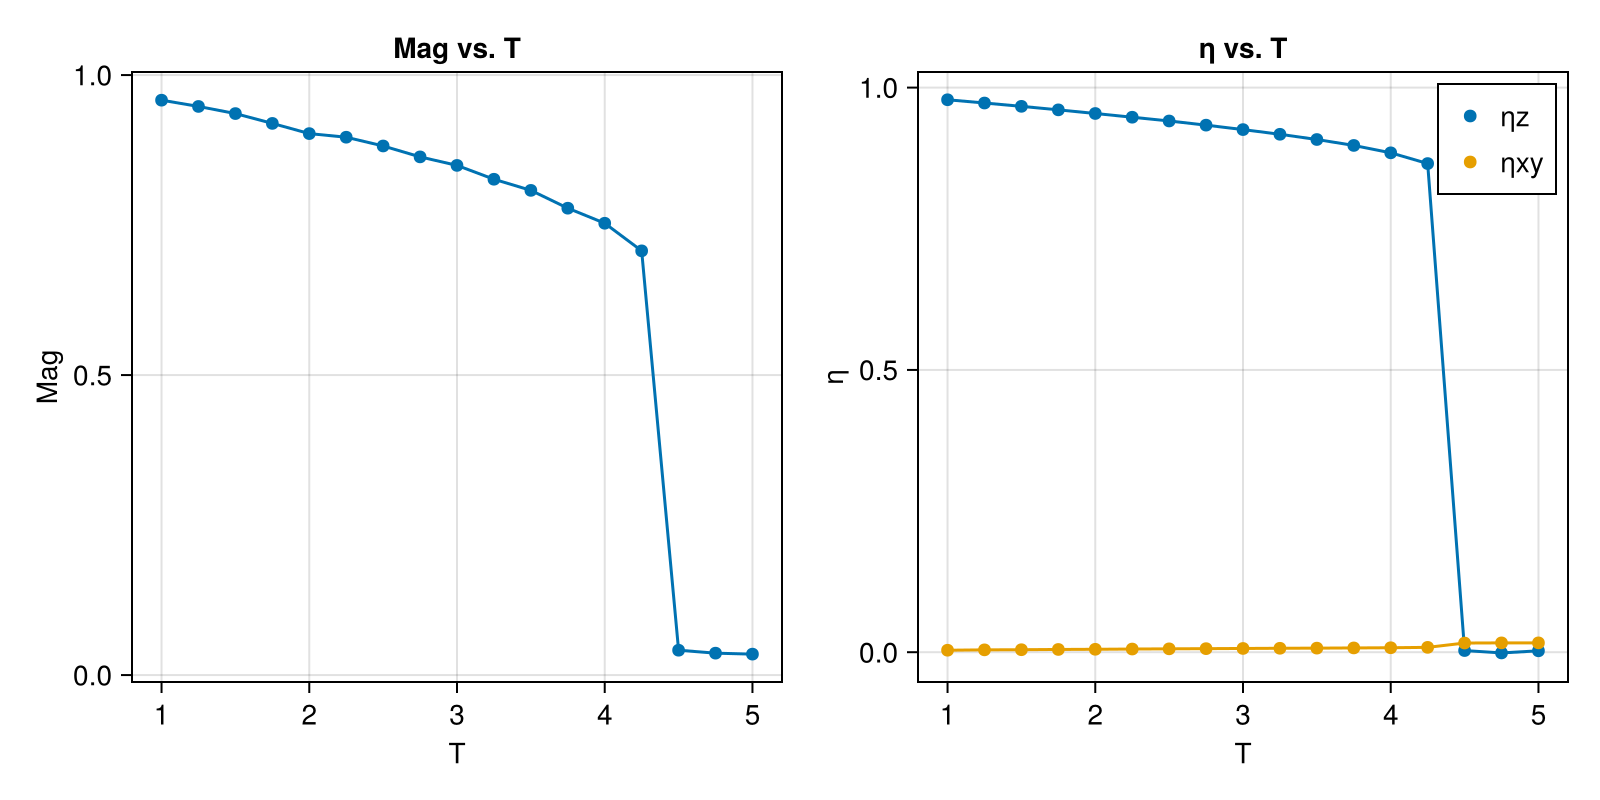

In [12]:
fig = Figure(size=(800, 400))
fig[1,1] = generatePlot(data, :T, :Mag; title="Mag vs. T", xlabel="T", ylabel="Mag", line=true)
fig[1,2] = generatePlot(data, :T, [:ηz, :ηxy]; title="η vs. T", xlabel="T", ylabel="η", line=true)
fig

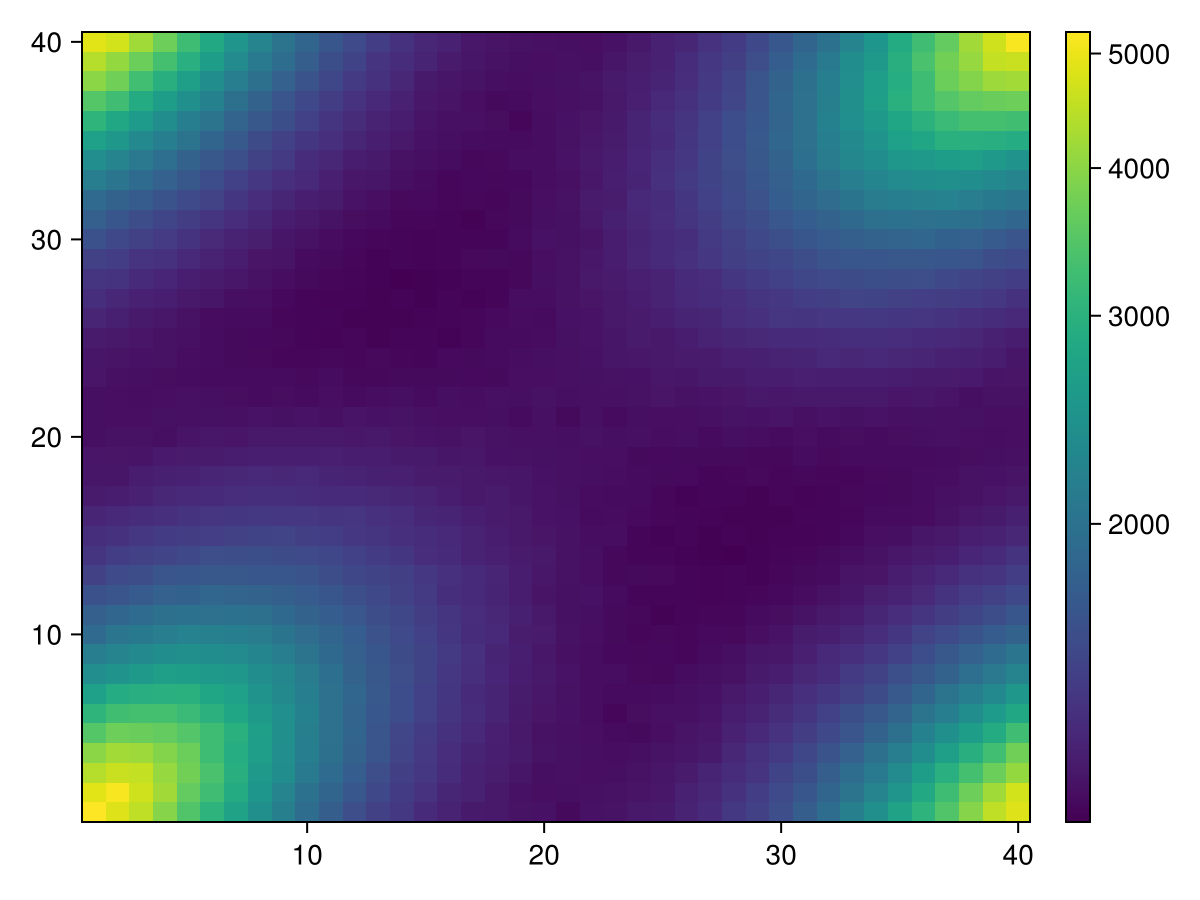

In [24]:
fig = Figure(size=(500, 500))
ax = fig[1,1] = Axis(fig; title="Spin_k")
scale = ReversibleScale(log)
spink_corrs = getfield.(data[15, :spink_corrs], :val)
fig, ax, hm = heatmap(spink_corrs, colorscale=scale)
Colorbar(fig[1, 2], hm)
fig

In [13]:
function generate_mctime_plot(task_no::Int, fig=Figure(size=(800, 400)), fig_pos=(1, 1))
    ax_P = fig[fig_pos...] = Axis(
        fig,
        title="Magnetization vs. Bin #",
        xlabel="Bin #",
        ylabel="Magnetization",
        xminorticksvisible=true
    )

    task_str = lpad(task_no, 4, "0")
    h5open("../jobs/$jobname.data/task$task_str/run0001.meas.h5") do file
        observables = file["observables"]

        mag_samples = read(observables, "Mag/samples")
        n = length(mag_samples)
        init = 1
        lines!(
            ax_P,
            collect(1:n),
            mag_samples[1:n],
        )
    end

    return fig
end

generate_mctime_plot (generic function with 3 methods)

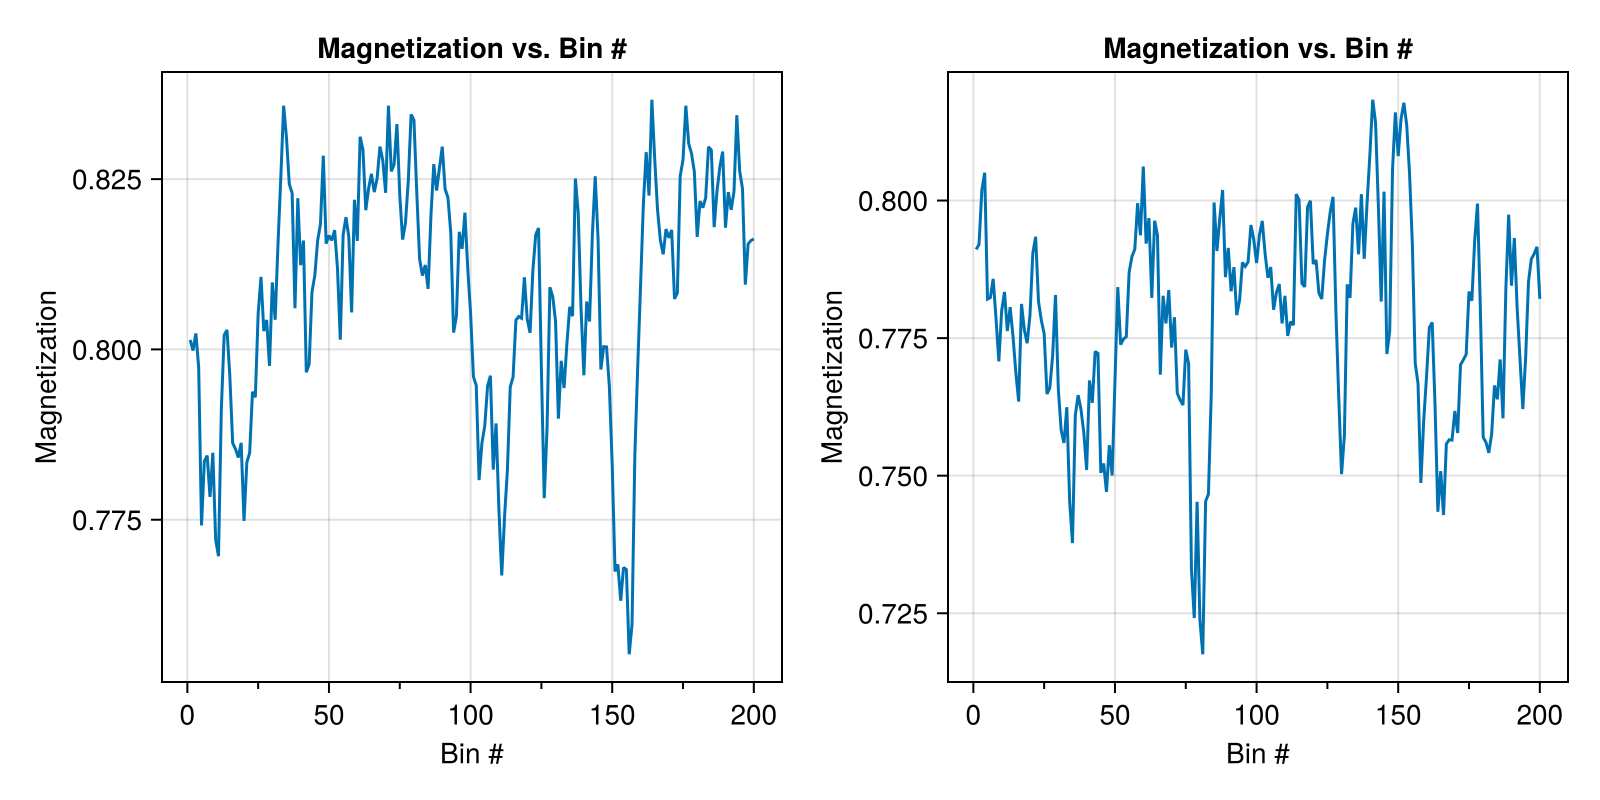

In [27]:
fig = Figure(size=(400, 800))
i = 11
fig = generate_mctime_plot(i)
generate_mctime_plot(i+1, fig, (1, 2))

In [15]:
function generate_spins(task_no::Int)
    fig = Figure(size=(800, 400))

    task_str = lpad(task_no, 4, "0")
    h5open("../jobs/$jobname.data/task$task_str/run0001.dump.h5") do file
        spins = map(
            t -> [t[:data][1], t[:data][2], t[:data][3]],
            read(file, "simulation/spins")
        )
        spin_xs = map(v -> v[1], spins)
        spin_ys = map(v -> v[2], spins)
        spin_zs = map(v -> v[3], spins)
        Lx, Ly = size(spins)
        fig[1,1] = Axis(fig; title="Spins", backgroundcolor="black")
        strength = vec(spin_zs)
        arrows2d!(1:Lx, 1:Ly, spin_xs, spin_ys, lengthscale=0.5, align=:center, color=strength,
                  colorrange=(-1, 1))

        ηs = map(
            t -> [t[:data][1], t[:data][2], t[:data][3]],
            read(file, "simulation/etas")
        )
        η_xs = getindex.(ηs, 1)
        η_ys = getindex.(ηs, 2)
        η_zs = getindex.(ηs, 3)
        Lx, Ly = size(ηs)
        fig[1,2] = Axis(fig; title="ηs", backgroundcolor="black")
        strength = vec(η_zs)
        arrows2d!(1:Lx, 1:Ly, η_xs, η_ys, lengthscale=0.5, align=:center, color=strength,
                  colorrange=(-1, 1))
    end

    return fig
end

generate_spins (generic function with 1 method)

## Annealed Random Initial State

In [6]:
anneal_results = JobResult("../jobs", "fm-anneal")

JobResult("../jobs", "fm-anneal", 17×23 DataFrame
 Row │ ηz               T        init_T  etak_corrs                         _l ⋯
     │ Measurem…        Float64  Int64   Array…                             Me ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 0.97863±0.00011     1.0       10  Complex{Measurement{Float64}}[5.…  0. ⋯
   2 │ 0.972657±9.6e-5     1.25      10  Complex{Measurement{Float64}}[6.…  0.
   3 │ 0.96682±0.00018     1.5       10  Complex{Measurement{Float64}}[8.…  0.
   4 │ 0.9605±0.00013      1.75      10  Complex{Measurement{Float64}}[9.…  0.
   5 │ 0.95425±0.00013     2.0       10  Complex{Measurement{Float64}}[11…  0. ⋯
   6 │ 0.94777±0.00018     2.25      10  Complex{Measurement{Float64}}[13…  0.
   7 │ 0.94078±0.0002      2.5       10  Complex{Measurement{Float64}}[14…  0.
   8 │ 0.9339±0.0002       2.75      10  Complex{Measurement{Float64}}[15…  0.
  ⋮  │        ⋮            ⋮       ⋮                     ⋮             

In [7]:
anneal_results[[:_ll_sweep_time, :_ll_measure_time]]

Row,_ll_sweep_time,_ll_measure_time
,Measurem…,Measurem…
1,0.0004149±2.5e-6,0.000197±3.8e-5
2,0.000414±1.9e-6,0.000164±1.6e-5
3,0.00041068±2.7e-7,0.000158±1.5e-5
4,0.0004126±1.7e-6,0.0001396±7.3e-6
5,0.000433±1.1e-5,0.000193±1.9e-5
6,0.0002633±1.1e-6,8.68e-5±4.1e-6
7,0.0002622±2.1e-6,0.000108±1.4e-5
8,0.0002673±2.0e-6,0.00012±1.7e-5
9,0.0002693±2.5e-6,0.0001065±9.7e-6


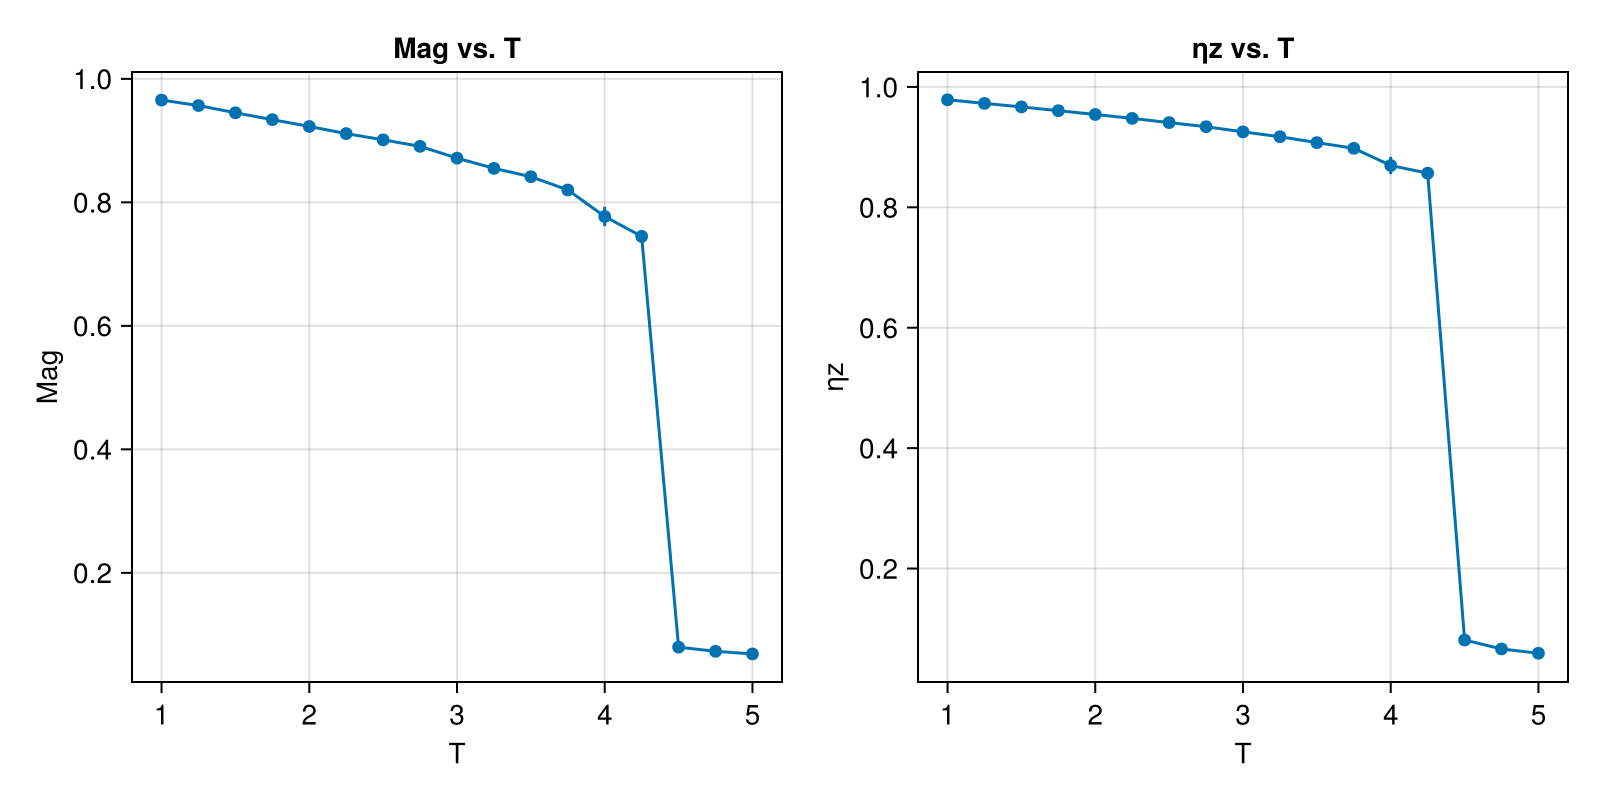

In [8]:
CairoMakie.activate!()

fig = Figure(size=(800, 400))
fig[1,1] = ax_s = Axis(fig, title="Mag vs. T", xlabel="T", ylabel="Mag")
generate_plot!(ax_s, :T, :Mag, anneal_results; line=true)
fig[1,2] = ax_η = Axis(fig, title="ηz vs. T", xlabel="T", ylabel="ηz")
generate_plot!(ax_η, :T, :ηz, anneal_results; line=true)
fig

In [9]:
anneal_mctimes = get_mctime_data(anneal_results, :Mag, :ηxy)

17-element Vector{DataFrame}:
 200×2 DataFrame
 Row │ Mag       ηxy        
     │ Float64   Float64    
─────┼──────────────────────
   1 │ 0.967724  0.00488963
   2 │ 0.967651  0.0103064
   3 │ 0.967286  0.00852725
   4 │ 0.969292  0.004879
   5 │ 0.969126  0.00551631
   6 │ 0.967792  0.00425153
   7 │ 0.962717  0.00666739
   8 │ 0.961229  0.00782382
  ⋮  │    ⋮          ⋮
 194 │ 0.96257   0.00910189
 195 │ 0.961453  0.00760304
 196 │ 0.962318  0.0115343
 197 │ 0.96261   0.00639576
 198 │ 0.962676  0.00821121
 199 │ 0.964127  0.00862234
 200 │ 0.967733  0.00421363
            185 rows omitted
 200×2 DataFrame
 Row │ Mag       ηxy        
     │ Float64   Float64    
─────┼──────────────────────
   1 │ 0.956501  0.00760902
   2 │ 0.958288  0.00682963
   3 │ 0.959764  0.00702801
   4 │ 0.959187  0.0068547
   5 │ 0.956459  0.00767257
   6 │ 0.955815  0.00893858
   7 │ 0.959261  0.00666676
   8 │ 0.958228  0.00624456
  ⋮  │    ⋮          ⋮
 194 │ 0.955048  0.00551677
 195 │ 0.957679  0.0

In [11]:
spink_corrs = anneal_results[:spink_corrs] ./ 400^2

17-element Vector{Matrix{Measurements.Measurement{Float64}}}:
 [0.9325 ± 0.0011 0.00264 ± 0.00026 … 0.0008 ± 8.3e-5 0.00264 ± 0.00026; 0.00271 ± 0.0003 0.00211 ± 0.00022 … 0.000464 ± 3.8e-5 0.000832 ± 7.1e-5; … ; 0.000772 ± 5.7e-5 0.000421 ± 2.5e-5 … 0.000656 ± 4.0e-5 0.000858 ± 6.7e-5; 0.00271 ± 0.0003 0.000832 ± 7.1e-5 … 0.000973 ± 8.5e-5 0.00211 ± 0.00022]
 [0.9154 ± 0.001 0.00275 ± 0.00022 … 0.000889 ± 7.2e-5 0.00275 ± 0.00022; 0.00248 ± 0.00028 0.00362 ± 0.00041 … 0.000541 ± 2.5e-5 0.00118 ± 9.2e-5; … ; 0.001021 ± 6.9e-5 0.000546 ± 3.7e-5 … 0.000884 ± 8.0e-5 0.001125 ± 9.0e-5; 0.00248 ± 0.00028 0.00118 ± 9.2e-5 … 0.001178 ± 8.6e-5 0.00362 ± 0.00041]
 [0.8931 ± 0.0013 0.00435 ± 0.0005 … 0.001005 ± 8.8e-5 0.00435 ± 0.0005; 0.00414 ± 0.00056 0.00406 ± 0.00042 … 0.00071 ± 2.9e-5 0.00161 ± 0.00014; … ; 0.001082 ± 5.1e-5 0.000649 ± 3.6e-5 … 0.00108 ± 8.3e-5 0.00144 ± 0.00011; 0.00414 ± 0.00056 0.00161 ± 0.00014 … 0.0016 ± 0.00015 0.00406 ± 0.00042]
 [0.8722 ± 0.002 0.00484 ± 0.00056 … 0

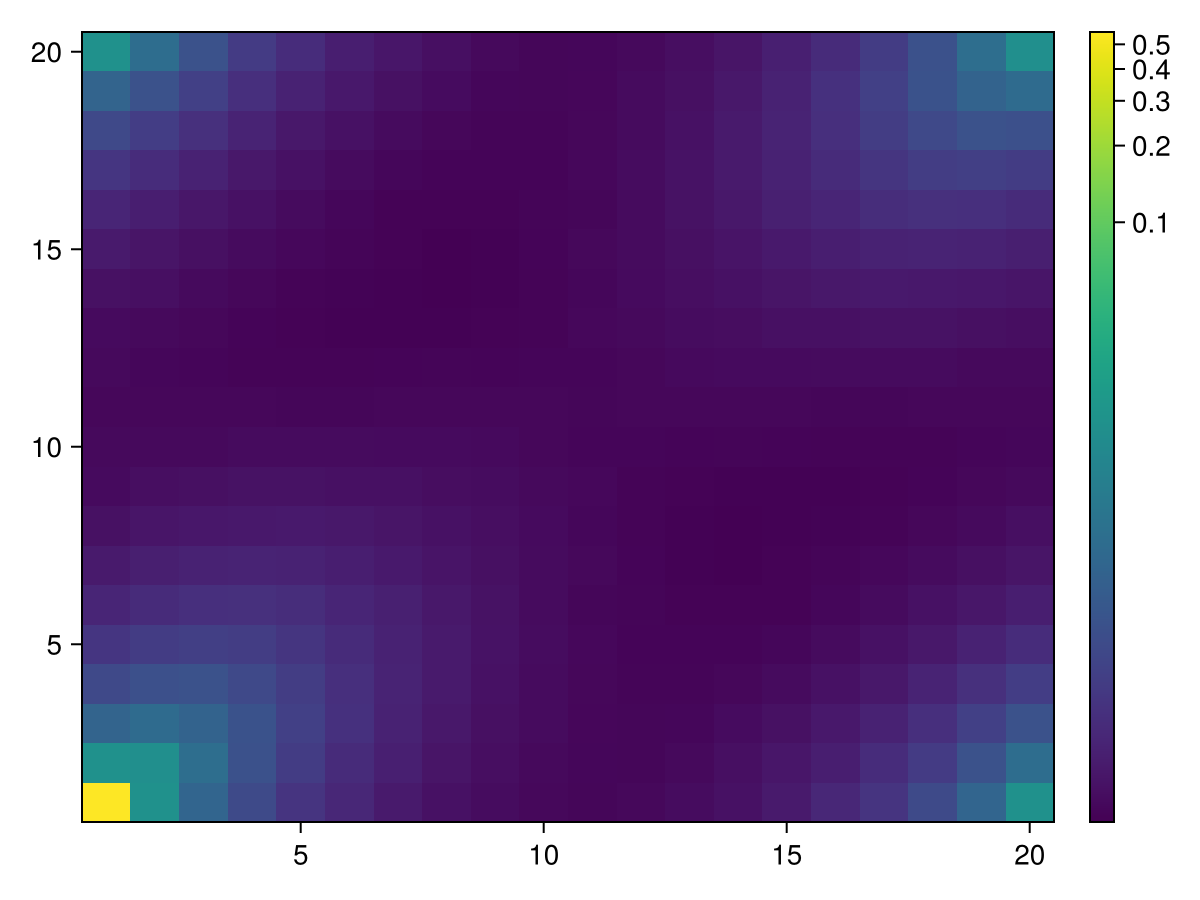

In [12]:
CairoMakie.activate!()
fig = Figure(size=(500, 500))
ax = fig[1,1] = Axis(fig; title="Spin_k")
scale = ReversibleScale(log)
fig, ax, hm = heatmap(getfield.(spink_corrs[14], :val), colorscale=scale)
Colorbar(fig[1, 2], hm)
fig

Any[(1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 3), (12, 5), (13, 7), (11, 6), (9, 5), (7, 4), (5, 3), (3, 2), (1, 1)]


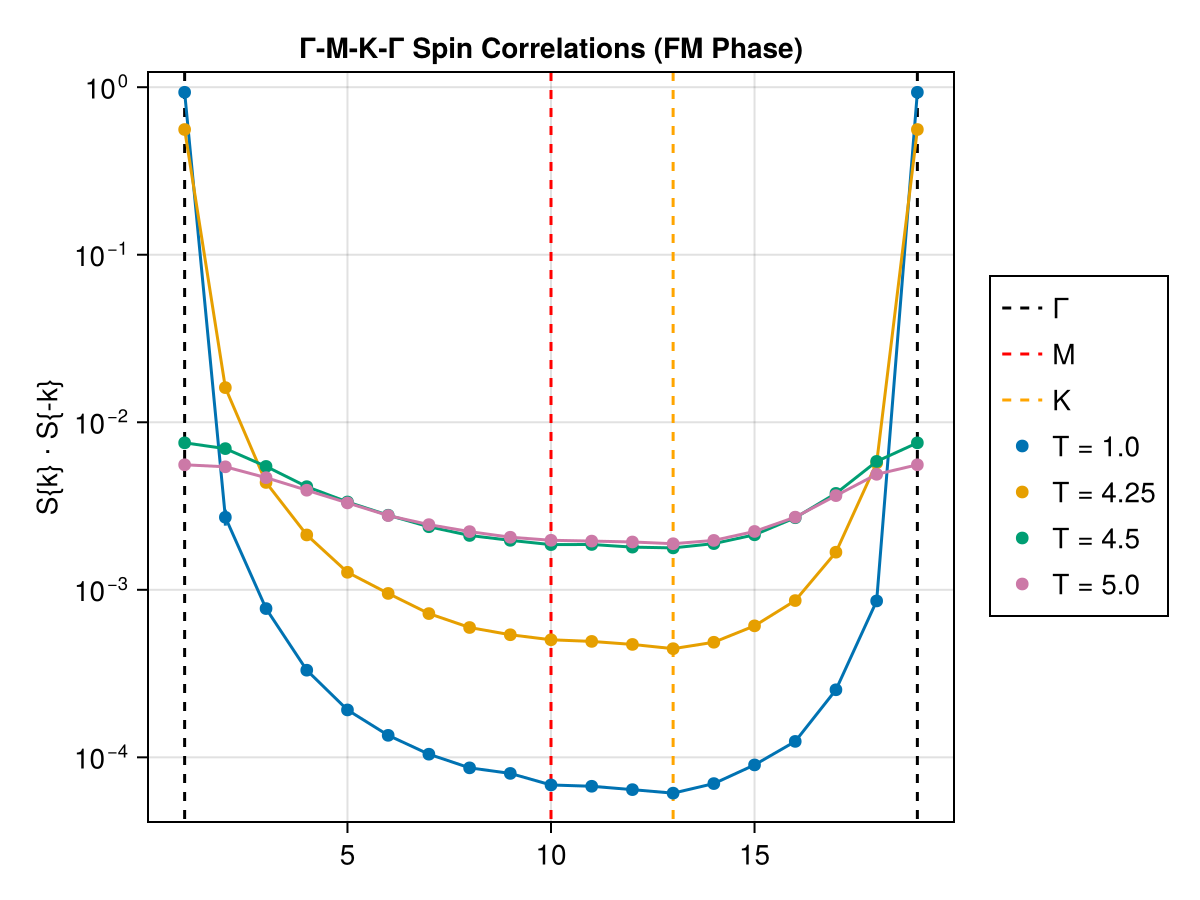

In [13]:
CairoMakie.activate!()
Lx, Ly = size(spink_corrs[1])
borderx = div(Lx, 2) + 1
bordery = div(Ly, 2) + 1

path = []
pos = (1, 1)
push!(path, pos)
while pos[1] < div(Lx, 2)
    pos = pos .+ (1, 0)
    push!(path, pos)
end
M_pos = length(path)
while pos[2] < div(Ly, 3)
    pos = pos .+ (1, 2)
    push!(path, pos)
end
K_pos = length(path)
while pos[2] > 1
    pos = pos .- (2, 1)
    push!(path, pos)
end
println(path)

fig = Figure()
fig[1, 1] = ax = Axis(
    fig,
    title="Γ-M-K-Γ Spin Correlations (FM Phase)",
    ylabel="S{k} ⋅ S{-k}",
    yscale=log10
)

min_corr = minimum(getfield.([spink_corrs[1][I...] for I in path], :val))
max_corr = maximum(getfield.([spink_corrs[1][I...] for I in path], :val))
lines!([(1, 2), (1, 1e-9)], color=:black, label="Γ", linestyle=:dash)
lines!([(M_pos, 2), (M_pos, 1e-9)], color=:red, label="M", linestyle=:dash)
lines!([(K_pos, 2), (K_pos, 1e-9)], color=:orange, label="K", linestyle=:dash)
lines!([(length(path), 2), (length(path), 1e-9)], color=:black, linestyle=:dash)
for i in [1, 14, 15, 17]
    corrs = [spink_corrs[i][I...] for I in path]
    scatter!(ax, corrs, label="T = $(anneal_results.data[i, :T])")
    errorbars!(ax, 1:length(path), getfield.(corrs, :val), getfield.(corrs, :err))
    lines!(ax, corrs)
end

ylims!(ax, (min_corr - 2e-5, max_corr + 0.3))
Legend(fig[1,2], ax)
fig

In [14]:
etak_corrs = anneal_results[:etak_corrs] ./ 400^2

17-element Vector{Array{Complex{Measurements.Measurement{Float64}}, 4}}:
 [3.38e-5 ± 1.5e-6 + 0.0 ± 0.0im 3.295e-5 ± 9.1e-7 + 0.0 ± 0.0im … 3.36e-5 ± 1.1e-6 + 0.0 ± 0.0im 3.295e-5 ± 9.1e-7 + 0.0 ± 0.0im; 3.42e-5 ± 1.3e-6 + 0.0 ± 0.0im 3.46e-5 ± 1.4e-6 + 0.0 ± 0.0im … 3.55e-5 ± 1.8e-6 + 0.0 ± 0.0im 3.42e-5 ± 1.4e-6 + 0.0 ± 0.0im; … ; 3.44e-5 ± 1.0e-6 + 0.0 ± 0.0im 3.57e-5 ± 1.0e-6 + 0.0 ± 0.0im … 3.447e-5 ± 9.9e-7 + 0.0 ± 0.0im 3.57e-5 ± 1.3e-6 + 0.0 ± 0.0im; 3.42e-5 ± 1.3e-6 + 0.0 ± 0.0im 3.42e-5 ± 1.4e-6 + 0.0 ± 0.0im … 3.418e-5 ± 8.7e-7 + 0.0 ± 0.0im 3.46e-5 ± 1.4e-6 + 0.0 ± 0.0im;;; 2.9e-7 ± 9.2e-7 + 0.0 ± 0.0im 3.2e-7 ± 1.2e-6 - 1.6386928853050638e-7 ± 0.0im … 3.2e-8 ± 1.3e-6 + 1.388845130728535e-6 ± 0.0im 3.2e-7 ± 1.2e-6 + 1.6386928853050638e-7 ± 0.0im; -2.4e-6 ± 1.4e-6 - 4.12821625892222e-8 ± 0.0im 6.3e-7 ± 9.8e-7 + 5.459570993538815e-7 ± 0.0im … -3.4e-7 ± 1.3e-6 - 4.943303948823876e-7 ± 0.0im 2.7e-7 ± 1.4e-6 + 8.26407251876103e-7 ± 0.0im; … ; -1.6e-6 ± 1.3e-6 - 7.485010955902096

Maximum correlation norm: 0.95772 ± 0.00021

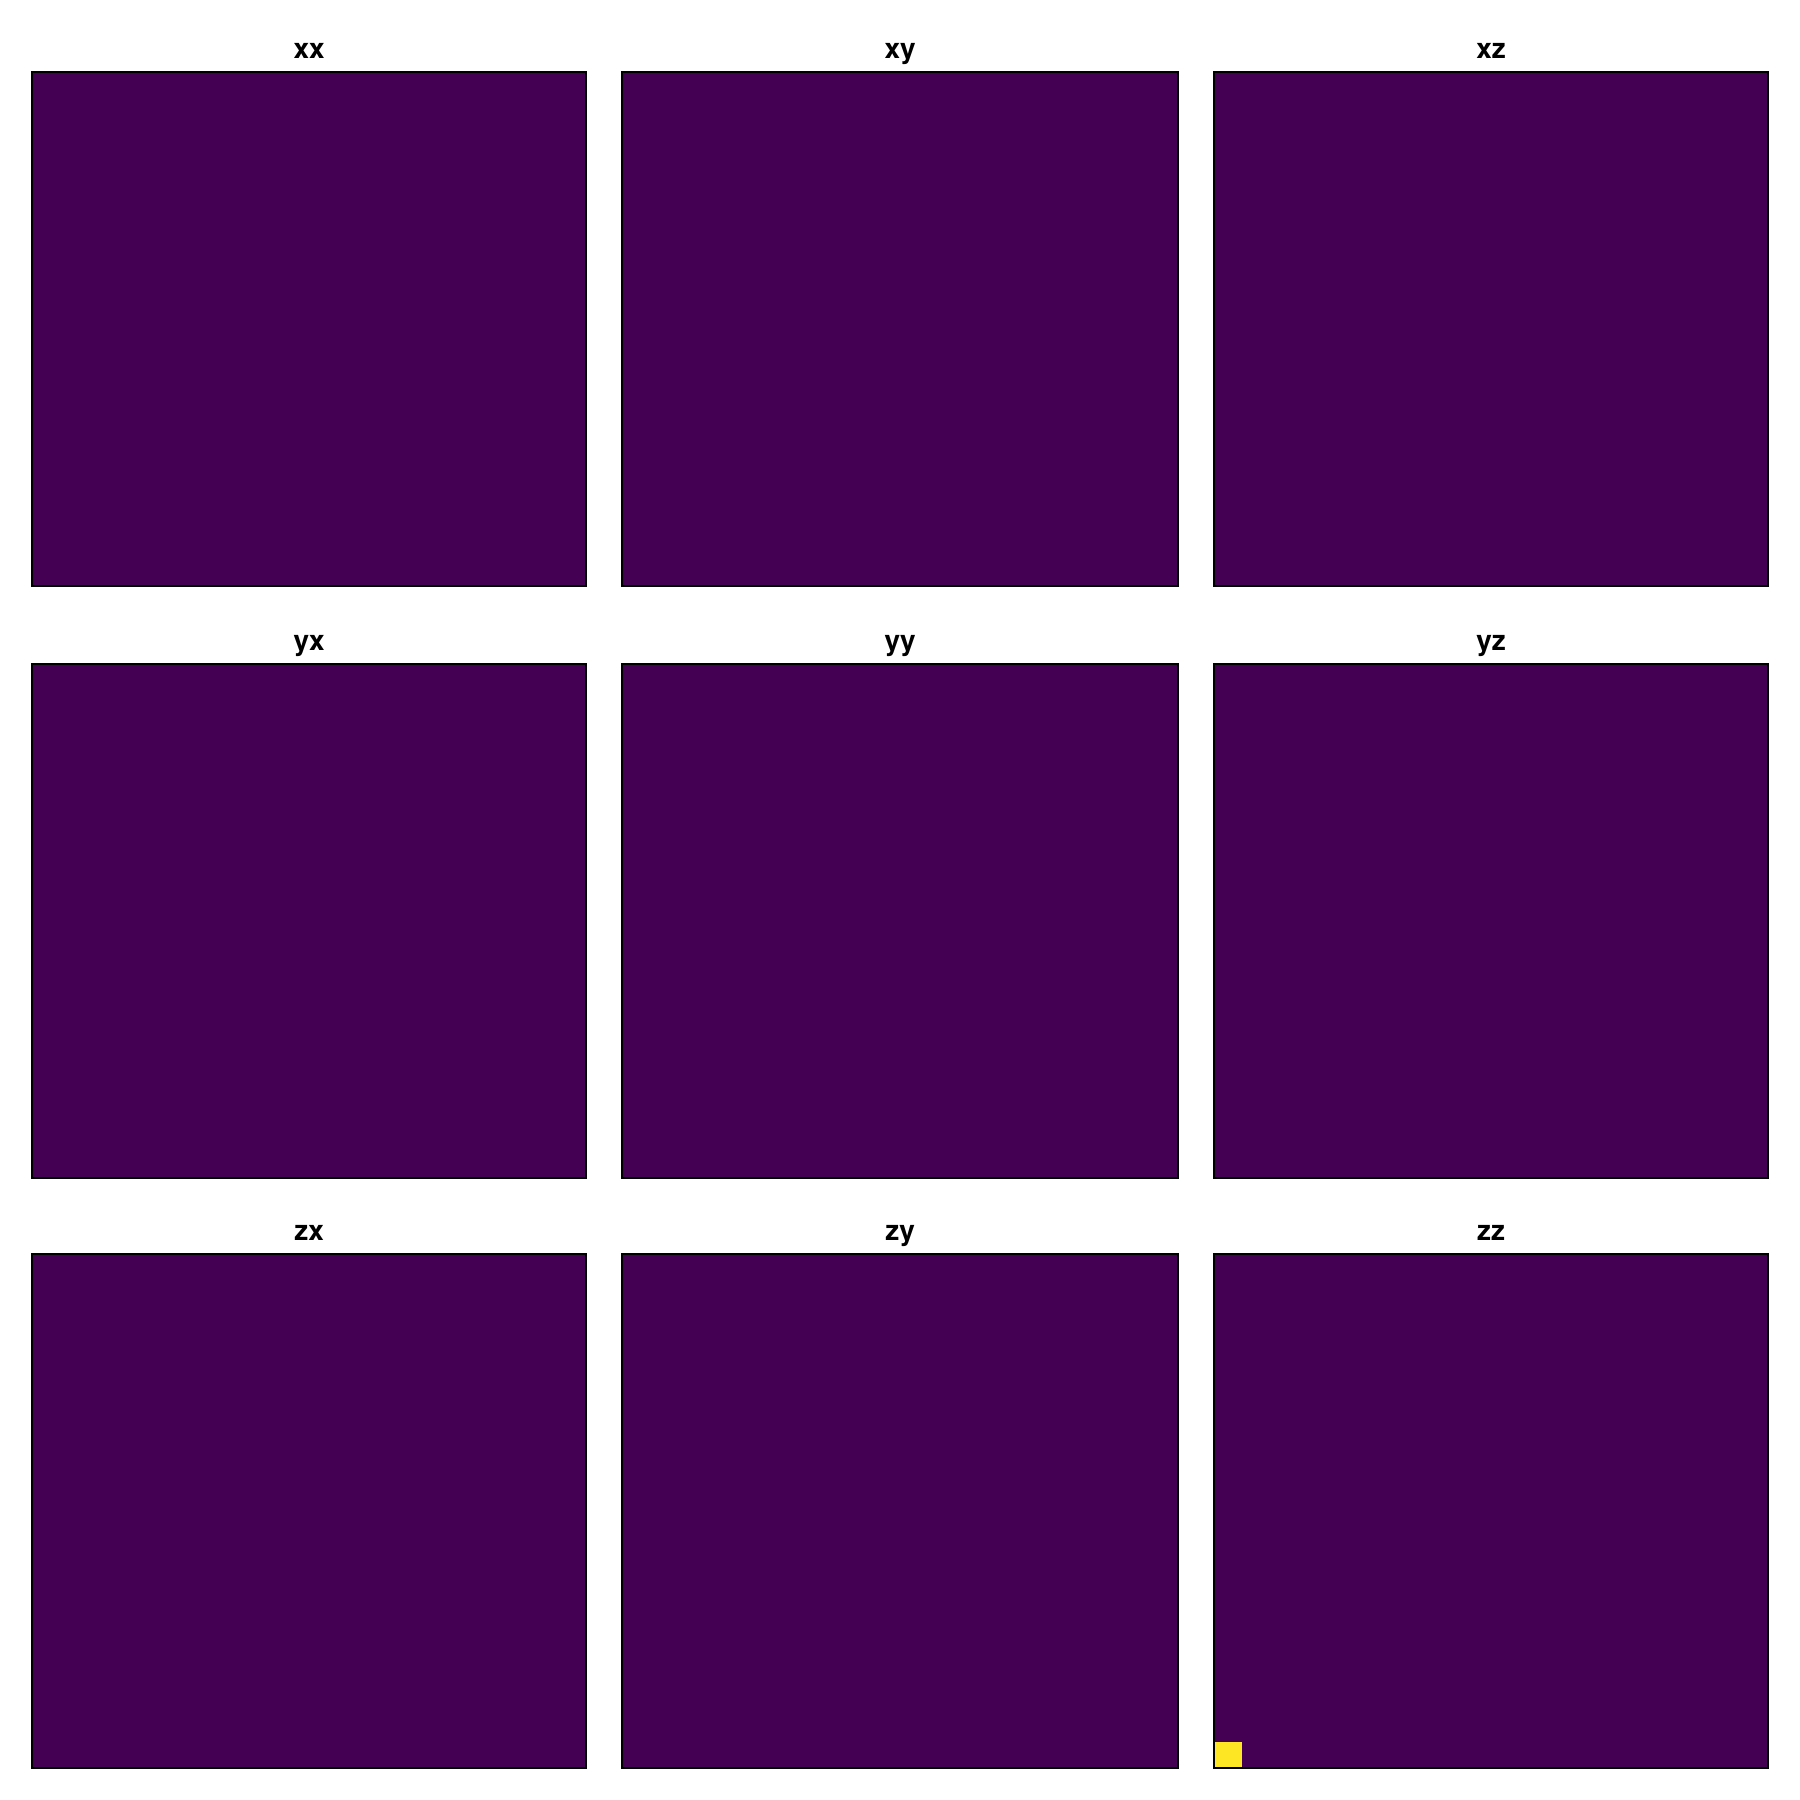

In [15]:
CairoMakie.activate!()

i = 1
fig = Figure(size=(900, 900))
labels = [:x, :y, :z]
scale = ReversibleScale(log)
corr_matrices = eachslice(etak_corrs[i], dims=(1, 2))
max_corrs = maximum(abs.(etak_corrs[i]))
min_corrs = minimum(abs.(etak_corrs[i]))
for x in 1:3
    for y in 1:3
        fig[x, y] = ax = Axis(fig, title="$(labels[x])$(labels[y])")
        corrs = getindex.(corr_matrices, x, y)
        heatmap!(ax, getfield.(abs.(corrs), :val), colorrange=(0, max_corrs.val))
        hidedecorations!(ax)
    end
end

print("Maximum correlation norm: $max_corrs")
fig